<a href="https://colab.research.google.com/github/AyushSinha2210/Machine_Learning/blob/main/TimeSeriesForecastingUsing_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd

def load_data(File_path):
  df = pd.read_csv(File_path)
  return df

In [9]:
a='/content/Tesla_stock_data.csv'
energy=load_data(a)[['Date', 'Volume']]
energy['Date'] = pd.to_datetime(energy['Date'])
energy = energy.set_index('Date')
energy.head()

,Volume
Date,
2010-06-29,281494500
2010-06-30,257806500
2010-07-01,123282000
2010-07-02,77097000
2010-07-06,103003500


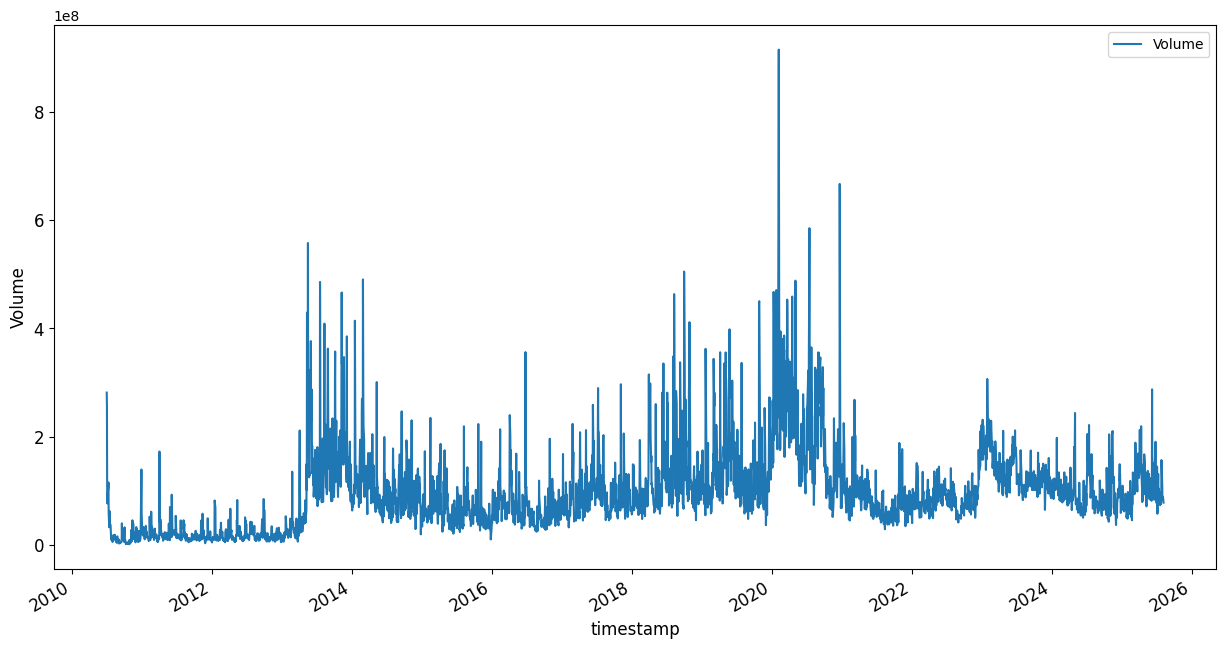

In [11]:
energy.plot(y='Volume', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

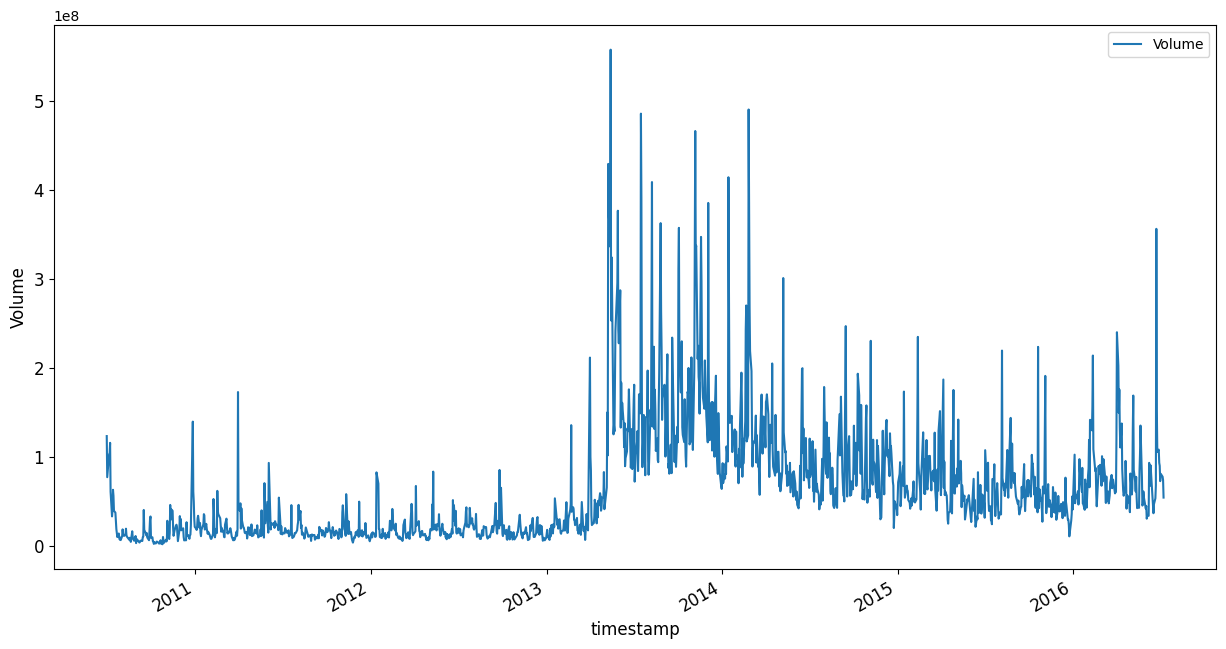

In [13]:
energy['2010-07-01':'2016-07-07'].plot(y='Volume', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

In [14]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [15]:
energy.head(10)

,Volume
Date,
2010-06-29,281494500
2010-06-30,257806500
2010-07-01,123282000
2010-07-02,77097000
2010-07-06,103003500
2010-07-07,103825500
2010-07-08,115671000
2010-07-09,60759000
2010-07-12,33037500


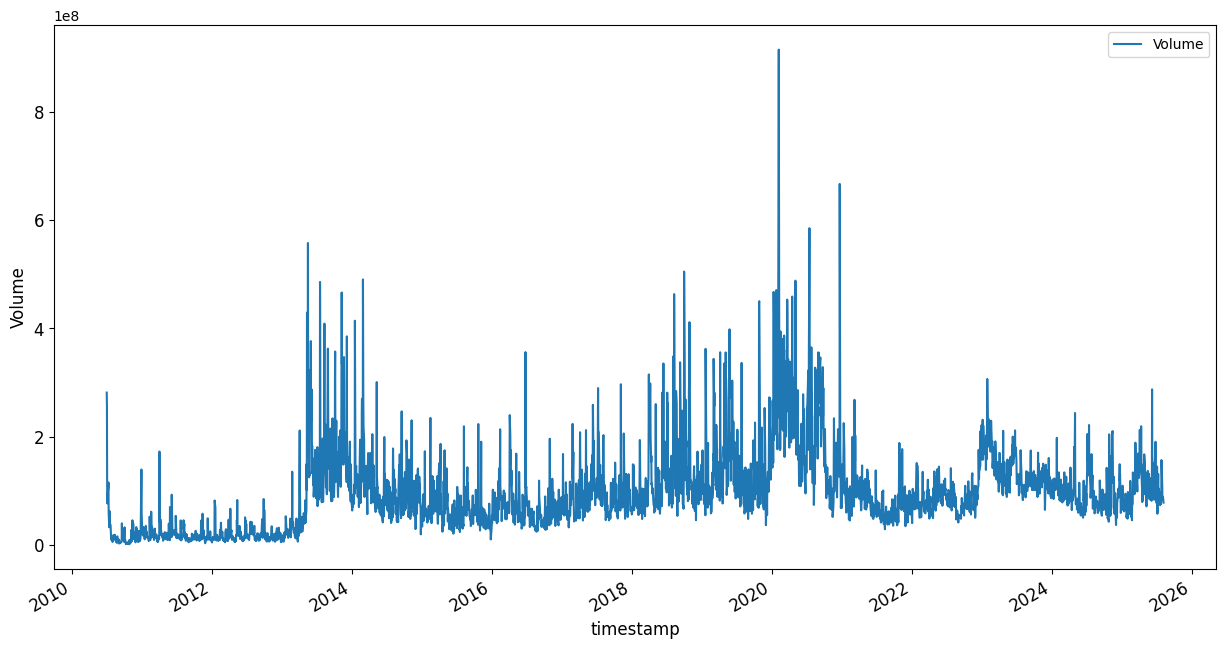

In [16]:
energy.plot(y='Volume', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

In [17]:
train_start_dt = '2010-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

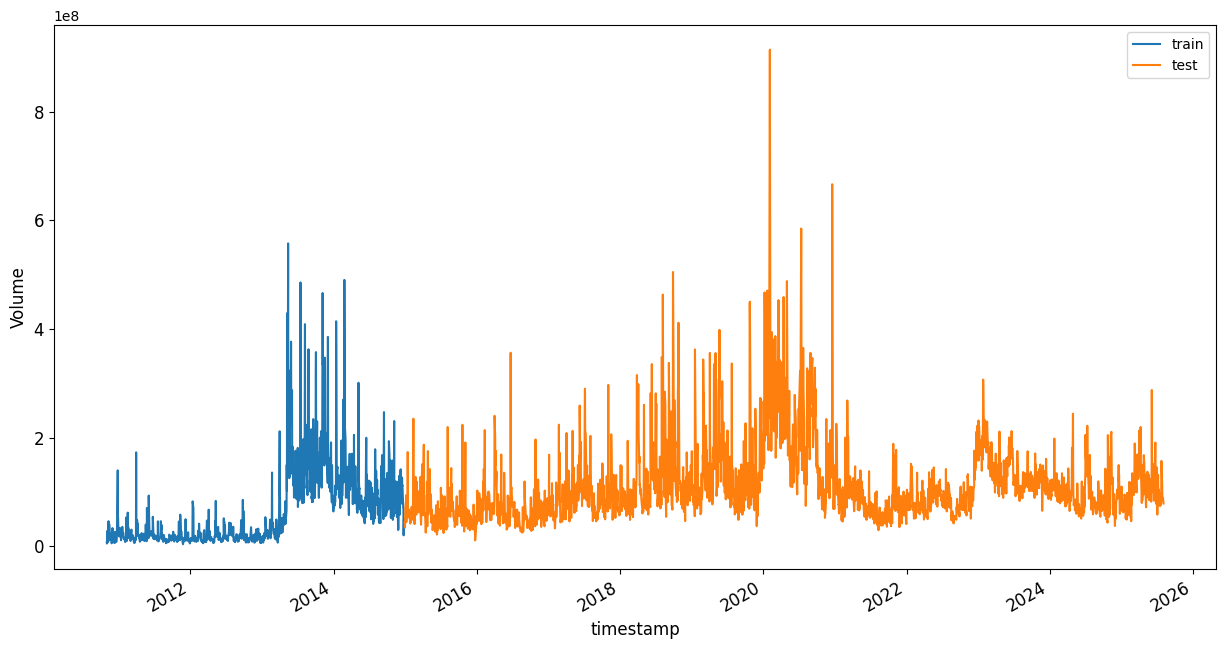

In [19]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['Volume']].rename(columns={'Volume':'train'}) \
    .join(energy[test_start_dt:][['Volume']].rename(columns={'Volume':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.show()

In [20]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Volume']]
test = energy.copy()[energy.index >= test_start_dt][['Volume']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1047, 1)
Test data shape:  (2664, 1)


In [21]:
scaler = MinMaxScaler()
train['Volume'] = scaler.fit_transform(train)
train.head(10)

,Volume
Date,
2010-11-01,0.01
2010-11-02,0.00
2010-11-03,0.00
2010-11-04,0.04
2010-11-05,0.02
2010-11-08,0.01
2010-11-09,0.02
2010-11-10,0.08
2010-11-11,0.05


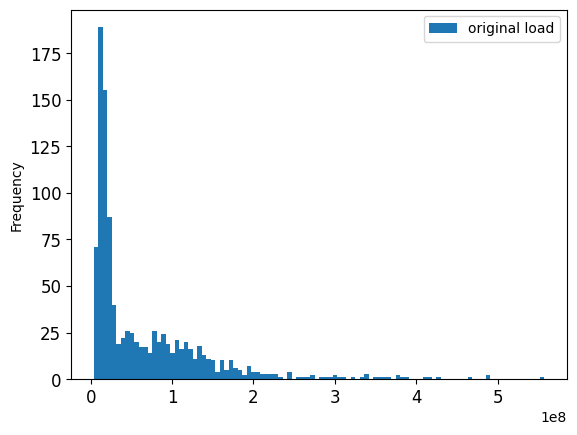

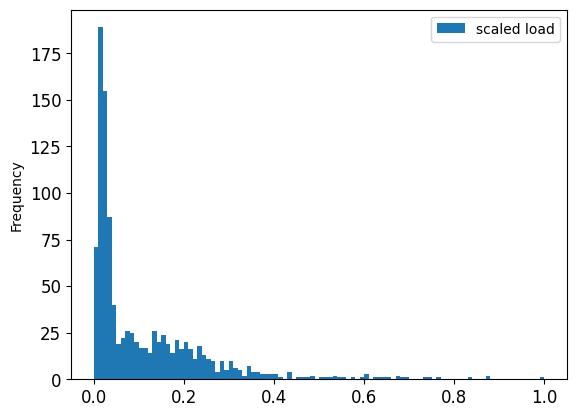

In [22]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Volume']].rename(columns={'Volume':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Volume':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [23]:
test['Volume'] = scaler.transform(test)
test.head()

,Volume
Date,
2014-12-30,0.07
2014-12-31,0.06
2015-01-02,0.12
2015-01-05,0.14
2015-01-06,0.16


**ARIME** **IMPLEMENTATION**

In [24]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [25]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                 1047
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                 930.195
Date:                            Sun, 28 Sep 2025   AIC                          -1848.390
Time:                                    05:41:16   BIC                          -1818.813
Sample:                                         0   HQIC                         -1837.160
                                           - 1047                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3186      0.021    -15.513      0.000      -0.359      -0.278
ar.L2         -0.2933      0.019   

In [29]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['Volume+'+str(t)] = test_shifted['Volume'].shift(-t, freq='D')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(4)

,Volume,Volume+1,Volume+2,Volume+3
Date,,,,
2015-01-05,0.14,0.16,0.07,0.09
2015-01-06,0.16,0.07,0.09,0.12
2015-01-12,0.15,0.11,0.31,0.13
2015-01-13,0.11,0.31,0.13,0.09


In [30]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['Volume']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2015-01-05 00:00:00
1 : predicted = [ 0.02 -0.   -0.03] expected = [0.1389031071679084, 0.16309855569367598, 0.07390255197796573, 0.08674233499348667]
2015-01-06 00:00:00
2 : predicted = [0.08 0.04 0.05] expected = [0.16309855569367598, 0.07390255197796573, 0.08674233499348667, 0.11993998532131958]
2015-01-12 00:00:00
3 : predicted = [0.1  0.1  0.28] expected = [0.15465966856514546, 0.1147672400018416, 0.3063646433378561, 0.13478657686130813]
2015-01-13 00:00:00
4 : predicted = [0.14 0.31 0.28] expected = [0.1147672400018416, 0.3063646433378561, 0.13478657686130813, 0.09109448249526735]
2015-01-20 00:00:00
5 : predicted = [0.29 0.27 0.19] expected = [0.11546867510013731, 0.10598440593322013, 0.10500672998540257, 0.08663671349219891]
2015-01-26 00:00:00
6 : predicted = [0.14 0.09 0.03] expected = [0.08110918825813895, 0.06882730342890725, 0.07880988942241289, 0.08960224025912475]
2015-01-27 00:00:00
7 : predicted = [ 0.05 -0.    0.03] expected = [0.06882730342890725, 0.07880988942241289

In [34]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')

def get_actual(row):
    horizon = int(row['h'].replace('t+', ''))
    return test_ts.loc[row['timestamp']]['Volume+'+str(horizon)]

eval_df['actual'] = eval_df.apply(get_actual, axis=1)

eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2015-01-05,t+1,"13,433,509.00","93,928,500.00"
1,2015-01-06,t+1,"49,648,152.25","44,526,000.00"
2,2015-01-12,t+1,"58,532,314.51","67,159,500.00"
3,2015-01-13,t+1,"81,229,436.62","173,278,500.00"
4,2015-01-20,t+1,"166,253,364.90","62,295,000.00"


In [35]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.41
t+2   0.48
t+3   0.50
Name: APE, dtype: float64


In [42]:
def mape(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [43]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual'])), '%')

One step forecast MAPE:  0.655541858671439 %


In [44]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual']), '%')

Multi-step forecast MAPE:  0.9169773570657679 %


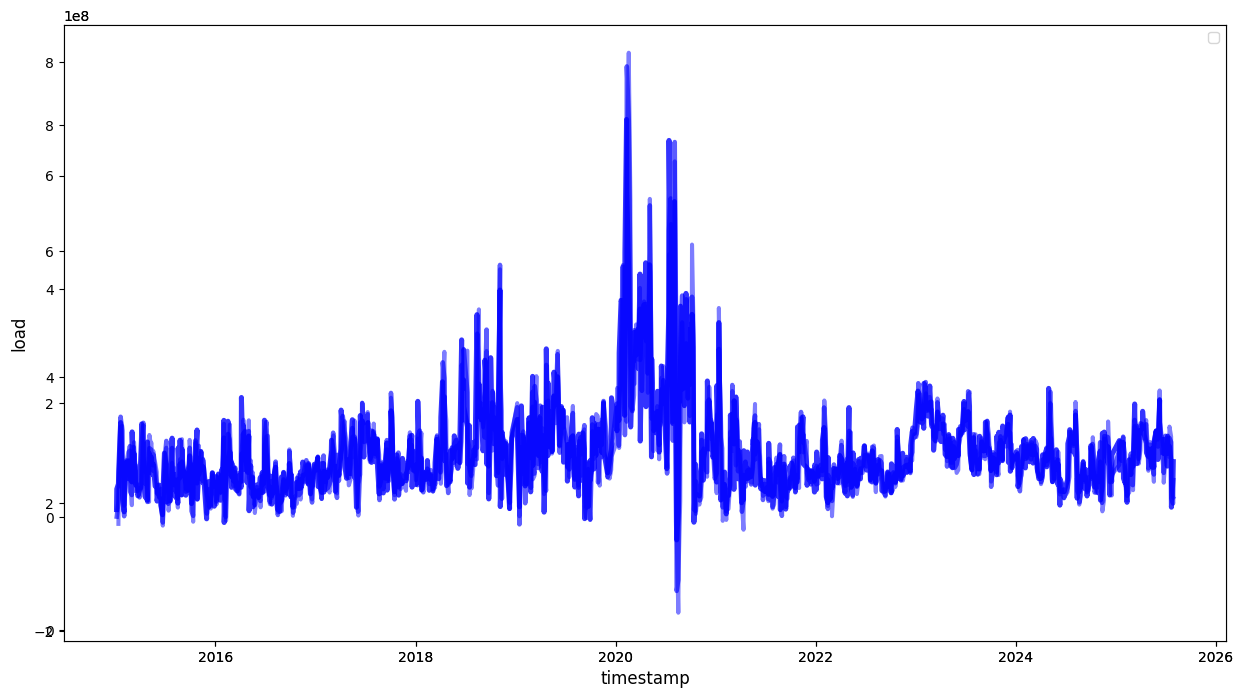

In [45]:
 if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()